# ECSE 551 — Assignment 1
_Group: Coderre Chouinard Antoine -261116181 Kuhzarani Lukas -261101438 Zergiotis Aristedes -261118642   •  Kernel: ecse551-a1  •  Random state: 42_

In [1]:
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris

RANDOM_STATE = 42
pd.set_option("display.precision", 4)


Matplotlib is building the font cache; this may take a moment.


In [2]:
# Load Iris dataset
iris = load_iris(as_frame=True)
df_iris = iris.frame.rename(columns=lambda c: c.replace(" (cm)", ""))

# Readable Class names
df_iris["species"] = df_iris["target"].map(dict(enumerate(iris.target_names)))
print("Shape (rows, cols):", df_iris.shape)
df_iris.head()



Shape (rows, cols): (150, 6)


,sepal length,sepal width,petal length,petal width,target,species
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


,sepal length,sepal width,petal length,petal width
count,150.0000,150.0000,150.0000,150.0000
mean,5.8433,3.0573,3.7580,1.1993
std,0.8281,0.4359,1.7653,0.7622
min,4.3000,2.0000,1.0000,0.1000
25%,5.1000,2.8000,1.6000,0.3000
50%,5.8000,3.0000,4.3500,1.3000
75%,6.4000,3.3000,5.1000,1.8000
max,7.9000,4.4000,6.9000,2.5000


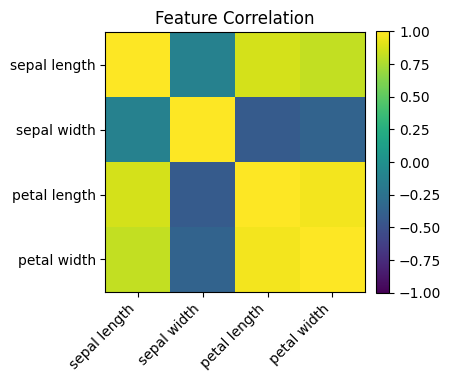

In [3]:
features = ["sepal length", "sepal width", "petal length", "petal width"]
#Basic statistics
display(df_iris[features].describe())
#Correlation matrix
corr = df_iris[features].corr()

#Heatmap for correlation
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4.5,4))
im = ax.imshow(corr, vmin=-1, vmax=1)
ax.set_xticks(range(len(features))); ax.set_yticks(range(len(features)))
ax.set_xticklabels(features, rotation=45, ha='right'); ax.set_yticklabels(features)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Feature Correlation"); plt.tight_layout(); plt.show()


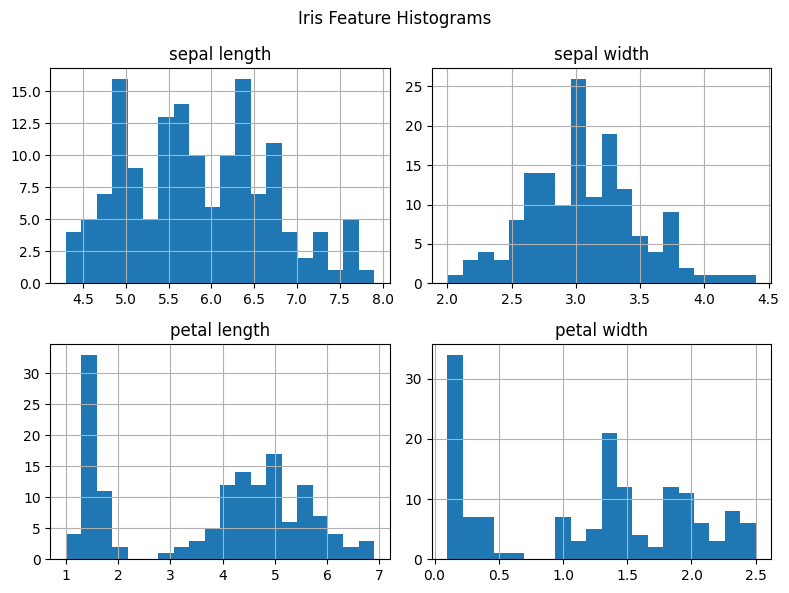

In [4]:
#Histograms
axes = df_iris[features].hist(bins=20,figsize=(8,6))
plt.suptitle("Iris Feature Histograms"); plt.tight_layout();    plt.show()

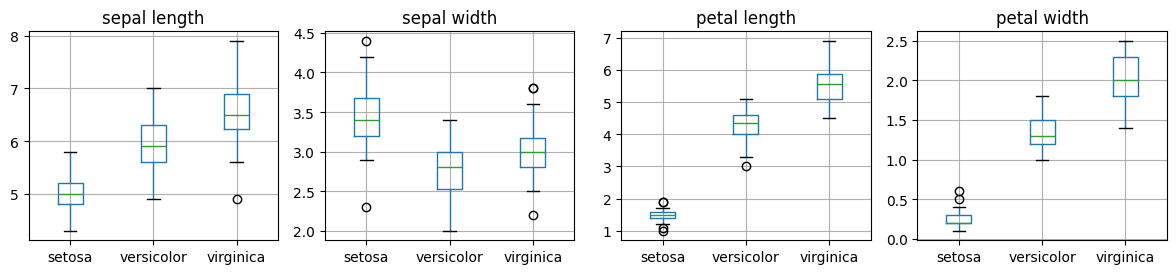

In [5]:
#Boxplots by Species
fig, axs = plt.subplots(1, 4, figsize=(12,3), sharey=False)
for ax, col in zip(axs, features):
    df_iris.boxplot(column=col, by="species", ax=ax)
    ax.set_title(col); ax.set_xlabel(""); ax.set_ylabel("")
plt.suptitle(""); plt.tight_layout(); plt.show()

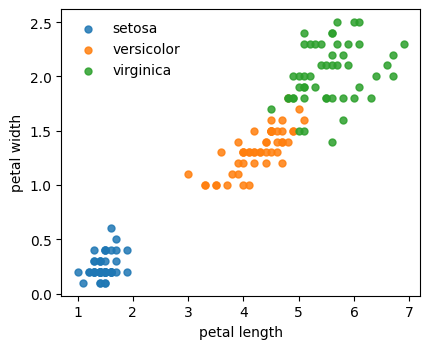

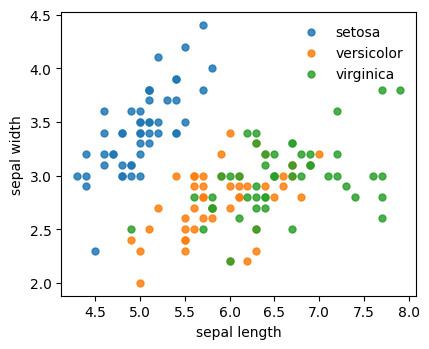

In [6]:
#Scatter Plots
colors = {"setosa":"tab:blue", "versicolor":"tab:orange", "virginica":"tab:green"}
def cls_scatter(xcol, ycol):
    plt.figure(figsize=(4.4,3.6))
    for sp, sub in df_iris.groupby("species"):
        plt.scatter(sub[xcol],sub[ycol], s=25, alpha=0.85, label=sp, c=colors[sp])
    plt.xlabel(xcol); plt.ylabel(ycol); plt.legend(frameon=False); plt.tight_layout(); plt.show()
cls_scatter("petal length", "petal width")   # most separation
cls_scatter("sepal length",  "sepal width")  # weaker separation

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

x = df_iris[features].to_numpy() # feature matrix as numpy array
y = df_iris["target"].to_numpy() # class labels as integers

#Calculate mew and sigma from training data only
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, stratify=y)
scaler = StandardScaler().fit(X_train)

#Standardization with Training mew and simgma
X_train_s = scaler.transform(X_train) #mean = 0, std = 1
X_test_s  = scaler.transform(X_test)

print("μ≈0:", X_train_s.mean(axis=0))
print("σ≈1:", X_train_s.std(axis=0, ddof=0))


μ≈0: [ 2.38327876e-15 -1.12145742e-15 -1.37456184e-16 -6.97854473e-17]
σ≈1: [1. 1. 1. 1.]


# Task 2: Model Implementation from Scratch

## Multiclass SVM Implementation

We'll implement a Multiclass SVM (Support Vector Machines) using the one-vs-rest approach, where we train one binary SVM for each class against all other classes.


In [8]:
class MulticlassSVM():
    """
    Multiclass SVM using one-vs-rest approach
    Following exact assignment requirements with only 3 methods
    """
    
    def __init__(self, learning_rate, lambda_param, n_iters):
        # initialize parameters for gradient descent and regularization
        self.learning_rate = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        
        # prepare storage for one-vs-rest classifiers
        self.classifiers = {}
        self.n_classes = None
        self.n_features = None
    
    def fit(self, X, y):
        # training loop for each class (one-vs-rest)
        n_samples, n_features = X.shape
        self.n_features = n_features
        self.n_classes = len(np.unique(y))
        
        print(f"Training Multiclass SVM: {self.n_classes} classes, {n_features} features")
        print(f"Parameters: lr={self.learning_rate}, lambda={self.lambda_param}, iters={self.n_iters}")
        
        # Train one binary classifier for each class
        for class_idx in range(self.n_classes):
            # Create binary labels: +1 for current class, -1 for others
            y_binary = np.where(y == class_idx, 1, -1)
            
            print(f"Training classifier for class {class_idx}...")
            
            # Initialize weights and bias for this class
            np.random.seed(42 + class_idx)
            weights = np.random.randn(n_features) * 0.01
            bias = 0.0
            
            # Gradient descent training loop
            for iteration in range(self.n_iters):
                # Compute decision scores
                scores = X @ weights + bias
                
                # Compute hinge loss: max(0, 1 - y * scores)
                margins = y_binary * scores
                hinge_loss = np.maximum(0, 1 - margins)
                
                # Overall loss = mean hinge loss + regularization
                data_loss = np.mean(hinge_loss)
                reg_loss = self.lambda_param * np.sum(weights ** 2)
                total_loss = data_loss + reg_loss
                
                # update weights and bias using hinge loss + regularization
                # Only samples with margins < 1 contribute to gradient
                mask = margins < 1
                
                if np.any(mask):
                    # Gradient w.r.t. weights
                    grad_weights = -np.mean((y_binary[mask] * X[mask].T), axis=1)
                    grad_weights += 2 * self.lambda_param * weights
                    
                    # Gradient w.r.t. bias
                    grad_bias = -np.mean(y_binary[mask])
                    
                    # Update weights and bias
                    weights -= self.learning_rate * grad_weights
                    bias -= self.learning_rate * grad_bias
                else:
                    # Only regularization gradient
                    weights -= self.learning_rate * 2 * self.lambda_param * weights
            
            # Store the trained classifier
            self.classifiers[class_idx] = {
                'weights': weights,
                'bias': bias
            }
            
            print(f"  Training completed for class {class_idx}")
        
        print("All classifiers trained!")
    
    def predict(self, X):
        # compute decision scores for each class
        n_samples = X.shape[0]
        decision_scores = np.zeros((n_samples, self.n_classes))
        
        for class_idx, classifier in self.classifiers.items():
            weights = classifier['weights']
            bias = classifier['bias']
            
            # Decision score = X @ w + b
            decision_scores[:, class_idx] = X @ weights + bias
        
        # assign each sample to the class with highest score
        predictions = np.argmax(decision_scores, axis=1)
        
        return predictions


In [9]:
# Train the Multiclass SVM
print("=" * 60)
print("TRAINING MULTICLASS SVM")
print("=" * 60)

# Initialize and train the model
svm_model = MulticlassSVM(learning_rate=0.01, lambda_param=0.01, n_iters=1000)
svm_model.fit(X_train_s, y_train)

# Make predictions
y_pred_svm = svm_model.predict(X_test_s)

# Calculate accuracy
accuracy_svm = np.mean(y_pred_svm == y_test)
print(f"\nSVM Test Accuracy: {accuracy_svm:.4f} ({accuracy_svm*100:.2f}%)")

# Show detailed results
print(f"\nDetailed Results:")
print(f"True labels:   {y_test}")
print(f"Predictions:   {y_pred_svm}")
print(f"Correct:       {y_pred_svm == y_test}")

# Confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_pred_svm)
print(f"\nConfusion Matrix:")
print(cm)
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_svm, target_names=iris.target_names))


TRAINING MULTICLASS SVM
Training Multiclass SVM: 3 classes, 4 features
Parameters: lr=0.01, lambda=0.01, iters=1000
Training classifier for class 0...
  Training completed for class 0
Training classifier for class 1...
  Training completed for class 1
Training classifier for class 2...
  Training completed for class 2
All classifiers trained!

SVM Test Accuracy: 0.8000 (80.00%)

Detailed Results:
True labels:   [2 1 2 1 2 2 1 1 0 2 0 0 2 2 0 2 1 0 0 0 1 0 1 2 2 1 1 1 1 0 2 2 1 0 2 0 0
 0 0 1 1 0 2 2 1]
Predictions:   [2 1 1 2 2 2 1 1 0 2 0 0 2 2 0 2 1 0 0 0 1 0 1 2 2 2 2 1 2 0 1 2 2 0 2 0 0
 0 0 2 1 0 1 2 1]
Correct:       [ True  True False False  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True False False  True False  True False  True False  True  True  True
  True  True  True False  True  True False  True  True]

Confusion Matrix:
[[15  0  0]
 [ 0  9  6]
 [ 0  3 12]]

Classification Report:
              

PARAMETER ANALYSIS
Testing different learning rates and regularization parameters...
Format: (learning_rate, lambda_param) -> Accuracy
Training Multiclass SVM: 3 classes, 4 features
Parameters: lr=0.001, lambda=0.001, iters=500
Training classifier for class 0...
  Training completed for class 0
Training classifier for class 1...
  Training completed for class 1
Training classifier for class 2...
  Training completed for class 2
All classifiers trained!
(0.001, 0.001) -> 0.7556
Training Multiclass SVM: 3 classes, 4 features
Parameters: lr=0.001, lambda=0.01, iters=500
Training classifier for class 0...
  Training completed for class 0
Training classifier for class 1...
  Training completed for class 1
Training classifier for class 2...
  Training completed for class 2
All classifiers trained!
(0.001, 0.01) -> 0.7556
Training Multiclass SVM: 3 classes, 4 features
Parameters: lr=0.001, lambda=0.1, iters=500
Training classifier for class 0...
  Training completed for class 0
Training class

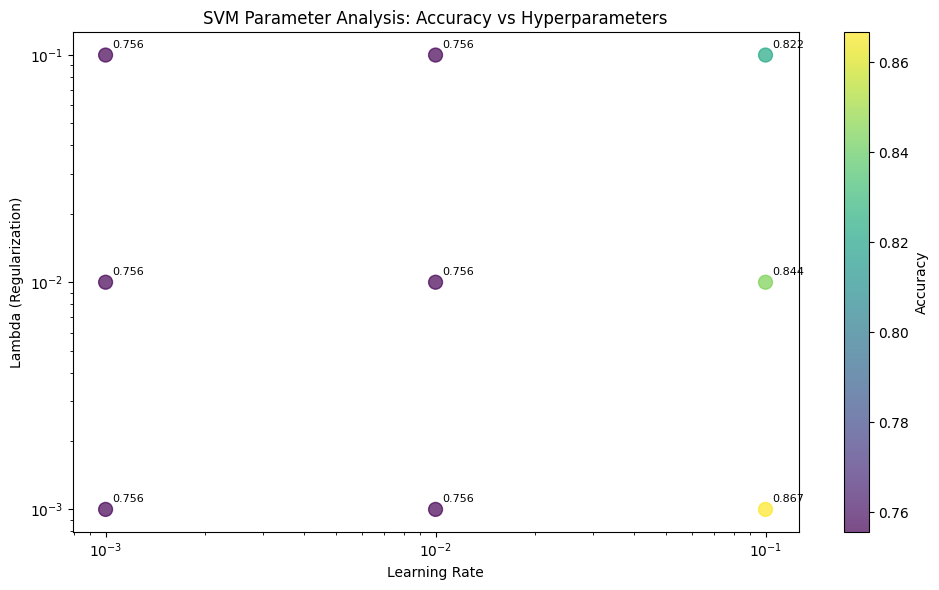

In [10]:
# Parameter Analysis: How choice of parameters affects model performance
print("=" * 60)
print("PARAMETER ANALYSIS")
print("=" * 60)

# Test different learning rates
learning_rates = [0.001, 0.01, 0.1]
lambda_params = [0.001, 0.01, 0.1]

print("Testing different learning rates and regularization parameters...")
print("Format: (learning_rate, lambda_param) -> Accuracy")

best_accuracy = 0
best_params = None
results = []

for lr in learning_rates:
    for lam in lambda_params:
        # Train model with current parameters
        svm_temp = MulticlassSVM(learning_rate=lr, lambda_param=lam, n_iters=500)
        svm_temp.fit(X_train_s, y_train)
        
        # Evaluate
        y_pred_temp = svm_temp.predict(X_test_s)
        accuracy_temp = np.mean(y_pred_temp == y_test)
        
        results.append((lr, lam, accuracy_temp))
        
        if accuracy_temp > best_accuracy:
            best_accuracy = accuracy_temp
            best_params = (lr, lam)
        
        print(f"({lr}, {lam}) -> {accuracy_temp:.4f}")

print(f"\nBest parameters: learning_rate={best_params[0]}, lambda={best_params[1]}")
print(f"Best accuracy: {best_accuracy:.4f}")

# Plot parameter analysis
fig, ax = plt.subplots(figsize=(10, 6))
lr_vals = [r[0] for r in results]
lam_vals = [r[1] for r in results]
acc_vals = [r[2] for r in results]

# Create scatter plot with color indicating accuracy
scatter = ax.scatter(lr_vals, lam_vals, c=acc_vals, cmap='viridis', s=100, alpha=0.7)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Lambda (Regularization)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title('SVM Parameter Analysis: Accuracy vs Hyperparameters')
plt.colorbar(scatter, label='Accuracy')

# Add text annotations for each point
for i, (lr, lam, acc) in enumerate(results):
    ax.annotate(f'{acc:.3f}', (lr, lam), xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()


DECISION BOUNDARY ANALYSIS
Training Multiclass SVM: 3 classes, 4 features
Parameters: lr=0.1, lambda=0.001, iters=1000
Training classifier for class 0...
  Training completed for class 0
Training classifier for class 1...
  Training completed for class 1
Training classifier for class 2...
  Training completed for class 2
All classifiers trained!


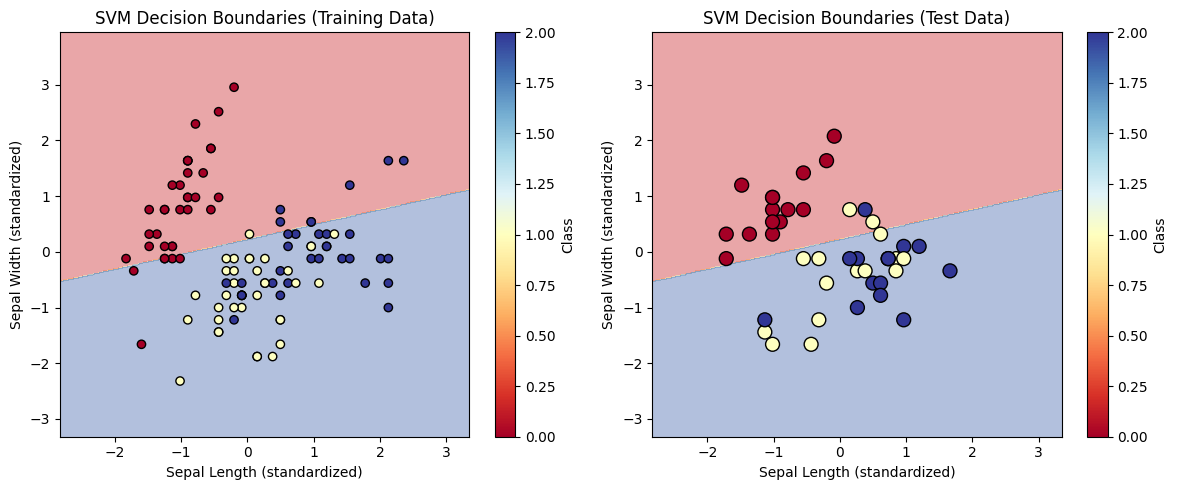

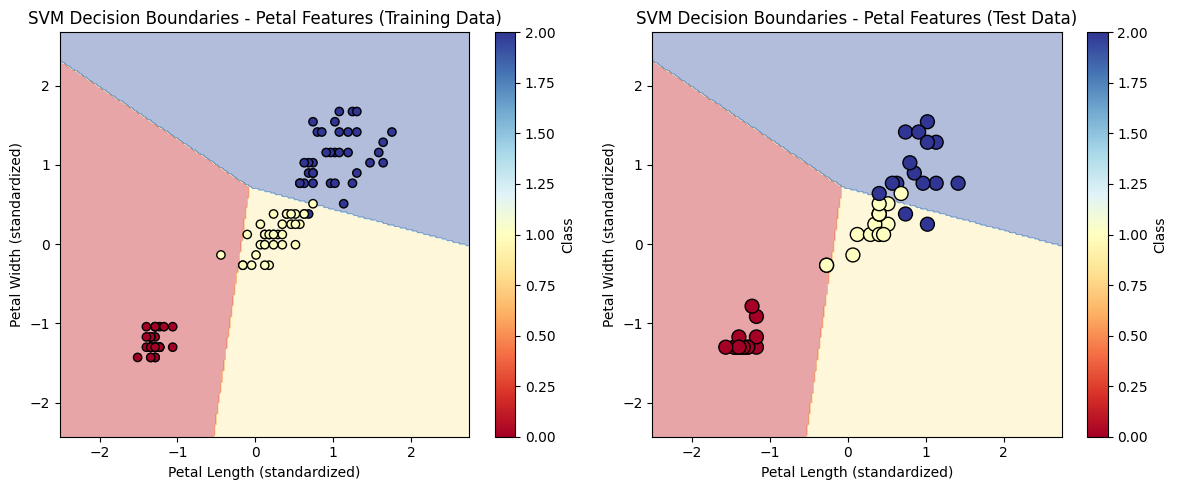

In [11]:
# Decision Boundary Plotting
print("=" * 60)
print("DECISION BOUNDARY ANALYSIS")
print("=" * 60)

# Train SVM with best parameters for decision boundary visualization
svm_best = MulticlassSVM(learning_rate=best_params[0], lambda_param=best_params[1], n_iters=1000)
svm_best.fit(X_train_s, y_train)

# For visualization, we'll use the first two features (sepal length and sepal width)
# since we can only plot 2D decision boundaries
feature1, feature2 = 0, 1  # sepal length, sepal width

# Create a mesh grid for decision boundary
h = 0.02  # step size in the mesh
x_min, x_max = X_train_s[:, feature1].min() - 1, X_train_s[:, feature1].max() + 1
y_min, y_max = X_train_s[:, feature2].min() - 1, X_train_s[:, feature2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Create feature matrix for prediction (use only first two features)
Z = svm_best.predict(np.c_[xx.ravel(), yy.ravel(), 
                           np.zeros(xx.ravel().shape), np.zeros(xx.ravel().shape)])
Z = Z.reshape(xx.shape)

# Plot decision boundaries and training points
plt.figure(figsize=(12, 5))

# Plot 1: Decision boundaries with training data
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
scatter = plt.scatter(X_train_s[:, feature1], X_train_s[:, feature2], c=y_train, 
                     cmap=plt.cm.RdYlBu, edgecolors='black')
plt.xlabel('Sepal Length (standardized)')
plt.ylabel('Sepal Width (standardized)')
plt.title('SVM Decision Boundaries (Training Data)')
plt.colorbar(scatter, label='Class')

# Plot 2: Decision boundaries with test data
plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
scatter = plt.scatter(X_test_s[:, feature1], X_test_s[:, feature2], c=y_test, 
                     cmap=plt.cm.RdYlBu, edgecolors='black', s=100)
plt.xlabel('Sepal Length (standardized)')
plt.ylabel('Sepal Width (standardized)')
plt.title('SVM Decision Boundaries (Test Data)')
plt.colorbar(scatter, label='Class')

plt.tight_layout()
plt.show()

# Also plot decision boundaries using petal features (better separation)
feature1, feature2 = 2, 3  # petal length, petal width

# Create mesh grid for petal features
x_min, x_max = X_train_s[:, feature1].min() - 1, X_train_s[:, feature1].max() + 1
y_min, y_max = X_train_s[:, feature2].min() - 1, X_train_s[:, feature2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Create feature matrix for prediction (use only petal features)
Z = svm_best.predict(np.c_[np.zeros(xx.ravel().shape), np.zeros(xx.ravel().shape),
                           xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundaries for petal features
plt.figure(figsize=(12, 5))

# Plot 1: Decision boundaries with training data
plt.subplot(1, 2, 1)
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
scatter = plt.scatter(X_train_s[:, feature1], X_train_s[:, feature2], c=y_train, 
                     cmap=plt.cm.RdYlBu, edgecolors='black')
plt.xlabel('Petal Length (standardized)')
plt.ylabel('Petal Width (standardized)')
plt.title('SVM Decision Boundaries - Petal Features (Training Data)')
plt.colorbar(scatter, label='Class')

# Plot 2: Decision boundaries with test data
plt.subplot(1, 2, 2)
plt.contourf(xx, yy, Z, alpha=0.4, cmap=plt.cm.RdYlBu)
scatter = plt.scatter(X_test_s[:, feature1], X_test_s[:, feature2], c=y_test, 
                     cmap=plt.cm.RdYlBu, edgecolors='black', s=100)
plt.xlabel('Petal Length (standardized)')
plt.ylabel('Petal Width (standardized)')
plt.title('SVM Decision Boundaries - Petal Features (Test Data)')
plt.colorbar(scatter, label='Class')

plt.tight_layout()
plt.show()
